# Data

In [ ]:
import torch
from torchvision.transforms import ToTensor
from torchvision import datasets

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 608kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.82MB/s]


In [ ]:
type(training_data)

torchvision.datasets.mnist.MNIST

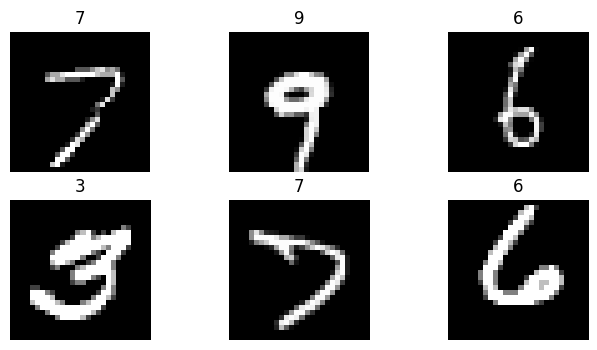

In [ ]:
import matplotlib.pyplot as plt

labels_map = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5",
               6: "6", 7: "7", 8: "8", 9: "9"}

figure = plt.figure(figsize=(8, 4))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle = False)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


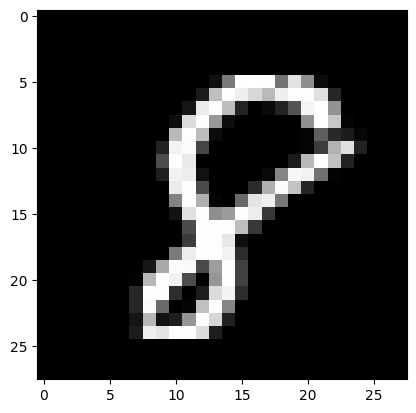

Label: 8


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

In [21]:

train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1, 10])


# Model

In [22]:
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork()
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [24]:
train_features, train_labels = next(iter(train_dataloader)) # Using a BS of 1
model(train_features)

tensor([[-0.0017,  0.0695, -0.0095, -0.0089, -0.0284, -0.0154, -0.0392, -0.0188,
         -0.0593,  0.0671]], grad_fn=<AddmmBackward0>)

In [25]:
probs = nn.Softmax(dim=1)(model(train_features))
print("Model softmax: \n", probs)

Model softmax: 
 tensor([[0.1002, 0.1076, 0.0994, 0.0995, 0.0976, 0.0988, 0.0965, 0.0985, 0.0946,
         0.1073]], grad_fn=<SoftmaxBackward0>)


In [29]:
y_pred = probs.argmax(1)
print(f"Predicted class: {y_pred.item()}")

Predicted class: 1


# Loss


In [30]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [31]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7ac9f47ebbe0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7ac9f47ebbe0>


In [32]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0911, 0.2002, 0.2530],
        [0.0911, 0.2002, 0.2530],
        [0.0911, 0.2002, 0.2530],
        [0.0911, 0.2002, 0.2530],
        [0.0911, 0.2002, 0.2530]])
tensor([0.0911, 0.2002, 0.2530])


In [33]:
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [34]:
optimizer.step()
optimizer.zero_grad()